Figure for MAtthew Henry paper comparing extreme precipitation from UKESM and CESM2 under ARISE SAI 1.5 scenario.

Plot two of the ETCCDI precip indices annual results from SSP245 in both models and ArISE in both modesl.

Uses M Henry code snippets to get similar output.

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import iris
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import cartopy.util as cutil
import cftime
import nc_time_axis
from scipy import stats

In [2]:
inCDir = '/glade/work/maritye/Data/ARISE-SAI/ETCCDI/'
inUDir = '/glade/work/maritye/Data/ARISE-SAI/UKESM/'
oDir = '/glade/work/maritye/Data/ARISE-SAI/Figures/'

File Names and file paths

In [3]:
#data...
#ukesm_ssp_pr_ave
ukesm_ssp_cdd_nm = inUDir + 'PRECT/SSP245/HadGEM_PRECT_full_u-be537.CDD_2020-2070_anoms.nc'
ukesm_ssp_rx5d_nm = inUDir + 'PRECT/SSP245/HadGEM_PRECT_full_u-be537.RX5D_2020-2070_anoms.nc'

ukesm_arise_cdd_nm = inUDir + 'PRECT/SAI-1.5/HadGEM_PRECT_full_u-cl322.CDD_2034-2070_anoms.nc'
ukesm_arise_rx5d_nm = inUDir + 'PRECT/SAI-1.5/HadGEM_PRECT_full_u-cl322.RX5D_2034-2070_anoms.nc'

## Need to recalculate the anomalies for CESM2
#cesm_ssp_pr_ave
cesm_ssp_cdd_nm = inCDir + 'SSP245/PRECT/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.CDD.2015-2069.nc'
cesm_ssp_rx5d_nm = inCDir + 'SSP245/PRECT/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.RX5D.2015-2069.nc'

cesm_arise_cdd_nm = inCDir + '/SAI-1.5/PRECT/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.cam.h1.CDD.2035-2069.nc'
cesm_arise_rx5d_nm = inCDir + '/SAI-1.5/PRECT/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.RX5D.2035-2069.nc'


Open the files. UKESM are pre-calculated as anomalies

In [4]:
with xr.open_dataset(ukesm_ssp_cdd_nm) as ds:
    ukesm_ssp_cdd_eoc = ds.CDD.sel(year=slice("2050","2069"))
    ukesm_ssp_cdd_soc = ds.CDD.sel(year=slice("2014", "2033"))

with xr.open_dataset(ukesm_arise_cdd_nm) as ds:
    ukesm_arise_cdd_eoc = ds.CDD.sel(year=slice("2050","2069"))

with xr.open_dataset(ukesm_arise_rx1d_nm) as ds:
    ukesm_arise_rx1d_eoc = ds.RX1D.sel(year=slice("2050","2069"))

with xr.open_dataset(ukesm_ssp_rx5d_nm) as ds:
    ukesm_ssp_rx5d_eoc = ds.RX5D.sel(year=slice("2050","2069"))
    ukesm_ssp_rx5d_soc = ds.RX5D.sel(year=slice("2014", "2033"))

with xr.open_dataset(ukesm_arise_rx5d_nm) as ds:
    ukesm_arise_rx5d_eoc = ds.RX5D.sel(year=slice("2050","2069"))


In [5]:
with xr.open_dataset(cesm_ssp_cdd_nm) as ds:
    cesm_ssp_cdd_eoc = ds.CDD.sel(year=slice("2050","2069"))
    cesm_ssp_cdd_soc = ds.CDD.sel(year=slice("2014", "2035"))

with xr.open_dataset(cesm_arise_cdd_nm) as ds:
    cesm_arise_cdd_eoc = ds.CDD.sel(year=slice("2050","2069"))

with xr.open_dataset(cesm_ssp_rx5d_nm) as ds:
    cesm_ssp_rx5d_eoc = ds.RX5D.sel(year=slice("2050","2069"))
    cesm_ssp_rx5d_soc = ds.RX5D.sel(year=slice("2014", "2035"))

with xr.open_dataset(cesm_arise_rx5d_nm) as ds:
    cesm_arise_rx5d_eoc = ds.RX5D.sel(year=slice("2050","2069"))


Calculate the CESM2 anomalies

In [6]:
cesm_cdd_base = cesm_ssp_cdd_soc.mean('year') # climatology to calculate anomalies
cesm_rx5d_base = cesm_ssp_rx5d_soc.mean('year')

cesm_ssp_cdd_anoms = cesm_ssp_cdd_eoc - cesm_cdd_base #anomalies
cesm_ssp_rx5d_anoms = cesm_ssp_rx5d_eoc - cesm_rx5d_base

cesm_arise_cdd_anoms = cesm_arise_cdd_eoc - cesm_cdd_base
cesm_arise_rx5d_anoms = cesm_arise_rx5d_eoc - cesm_rx5d_base

cesm_ssp_cdd_anom_base = cesm_ssp_cdd_soc - cesm_cdd_base
cesm_ssp_rx5d_anom_base = cesm_ssp_rx5d_soc - cesm_rx5d_base

Calculate the statistical significance for UKESM1 and CEMS2

In [56]:
### Create some standard information to include in each of the datasets for ease of writing

members = (range(5), range(10))
lat = (ukesm_ssp_cdd_soc.lat, cesm_ssp_cdd_soc.lat)
lon = (ukesm_ssp_cdd_soc.lon, cesm_ssp_cdd_soc.lon)
dims = ('member', 'lat', 'lon')


In [134]:
#UKESM1 
puk_cdd_ssp = xr.DataArray(None, coords=dict(member=members[0], lat = lat[0], lon = lon[0]), dims=dims, name='pval')
puk_cdd_arise = xr.DataArray(None, coords=dict(member=members[0], lat = lat[0], lon = lon[0]), dims=dims, name='pval')
puk_rx5d_ssp = xr.DataArray(None, coords=dict(member=members[0], lat = lat[0], lon = lon[0]), dims=dims, name='pval')
puk_rx5d_arise = xr.DataArray(None, coords=dict(member=members[0], lat = lat[0], lon = lon[0]), dims=dims, name='pval')

for i in range(5):
    r1 = ukesm_ssp_cdd_soc.sel(member=i)
    r2 = ukesm_ssp_cdd_eoc.sel(member=i)
    r3 = ukesm_arise_cdd_eoc.sel(member=i)
    foo = stats.ttest_ind(r1,r2).pvalue
    boo = stats.ttest_ind(r1,r3).pvalue
    puk_cdd_ssp[i,:,:] = xr.DataArray(foo)
    puk_cdd_arise[i,:,:] = xr.DataArray(boo)
    
    r1 = ukesm_ssp_rx5d_soc.sel(member=i)
    r2 = ukesm_ssp_rx5d_eoc.sel(member=i)
    r3 = ukesm_arise_rx5d_eoc.sel(member=i)
    foo = stats.ttest_ind(r1,r2).pvalue
    boo = stats.ttest_ind(r1,r3).pvalue
    puk_rx5d_ssp[i,:,:] = xr.DataArray(foo)
    puk_rx5d_arise[i,:,:] = xr.DataArray(boo)


puk_cdd_ssp = puk_cdd_ssp.min('member').astype('float64')
puk_rx5d_ssp = puk_rx5d_ssp.min('member').astype('float64')

puk_cdd_arise = puk_cdd_arise.min('member').astype('float64')
puk_rx5d_arise = puk_rx5d_arise.min('member').astype('float64')

In [135]:
#CESM2
pcesm_cdd_ssp = xr.DataArray(None, coords=dict(member=members[1], lat = lat[1], lon = lon[1]), dims=dims, name='pval')
pcesm_cdd_arise = xr.DataArray(None, coords=dict(member=members[1], lat = lat[1], lon = lon[1]), dims=dims, name='pval')
pcesm_rx5d_ssp = xr.DataArray(None, coords=dict(member=members[1], lat = lat[1], lon = lon[1]), dims=dims, name='pval')
pcesm_rx5d_arise = xr.DataArray(None, coords=dict(member=members[1], lat = lat[1], lon = lon[1]), dims=dims, name='pval')

for i in range(10):
    r1 = cesm_ssp_cdd_anom_base.isel(member=i)
    r2 = cesm_ssp_cdd_anoms.isel(member=i)
    r3 = cesm_arise_cdd_anoms.isel(member=i)
    foo = stats.ttest_ind(r1,r2).pvalue
    boo = stats.ttest_ind(r1,r3).pvalue
    pcesm_cdd_ssp[i,:,:] = xr.DataArray(foo)
    pcesm_cdd_arise[i,:,:] = xr.DataArray(boo)
    
    r1 = cesm_ssp_rx5d_anom_base.isel(member=i)
    r2 = cesm_ssp_rx5d_anoms.isel(member=i)
    r3 = cesm_arise_rx5d_anoms.isel(member=i)
    foo = stats.ttest_ind(r1,r2).pvalue
    boo = stats.ttest_ind(r1,r3).pvalue
    pcesm_rx5d_ssp[i,:,:] = xr.DataArray(foo)
    pcesm_rx5d_arise[i,:,:] = xr.DataArray(boo)

pcesm_cdd_ssp = pcesm_cdd_ssp.min('member').astype('float64')
pcesm_rx5d_ssp = pcesm_rx5d_ssp.min('member').astype('float64')

pcesm_cdd_arise = pcesm_cdd_arise.min('member').astype('float64')
pcesm_rx5d_arise = pcesm_rx5d_arise.min('member').astype('float64') 

In [139]:
#For Plotting
ukesm_ssp_cdd = ukesm_ssp_cdd_eoc.mean(['year','member'])
ukesm_ssp_rx5d = ukesm_ssp_rx5d_eoc.mean(['year','member'])

ukesm_arise_cdd = ukesm_arise_cdd_eoc.mean(['year','member'])
ukesm_arise_rx5d = ukesm_arise_rx5d_eoc.mean(['year','member'])

In [53]:
#For Plotting
cesm_ssp_cdd = cesm_ssp_cdd_anoms.mean(['year','member'])
cesm_ssp_rx5d = cesm_ssp_rx5d_anoms.mean(['year','member'])

cesm_arise_cdd = cesm_arise_cdd_anoms.mean(['year','member'])
cesm_arise_rx5d = cesm_arise_rx5d_anoms.mean(['year','member'])

Figure Option 1: With significance hatching. As MH figures

TypeError: No numeric data to plot.

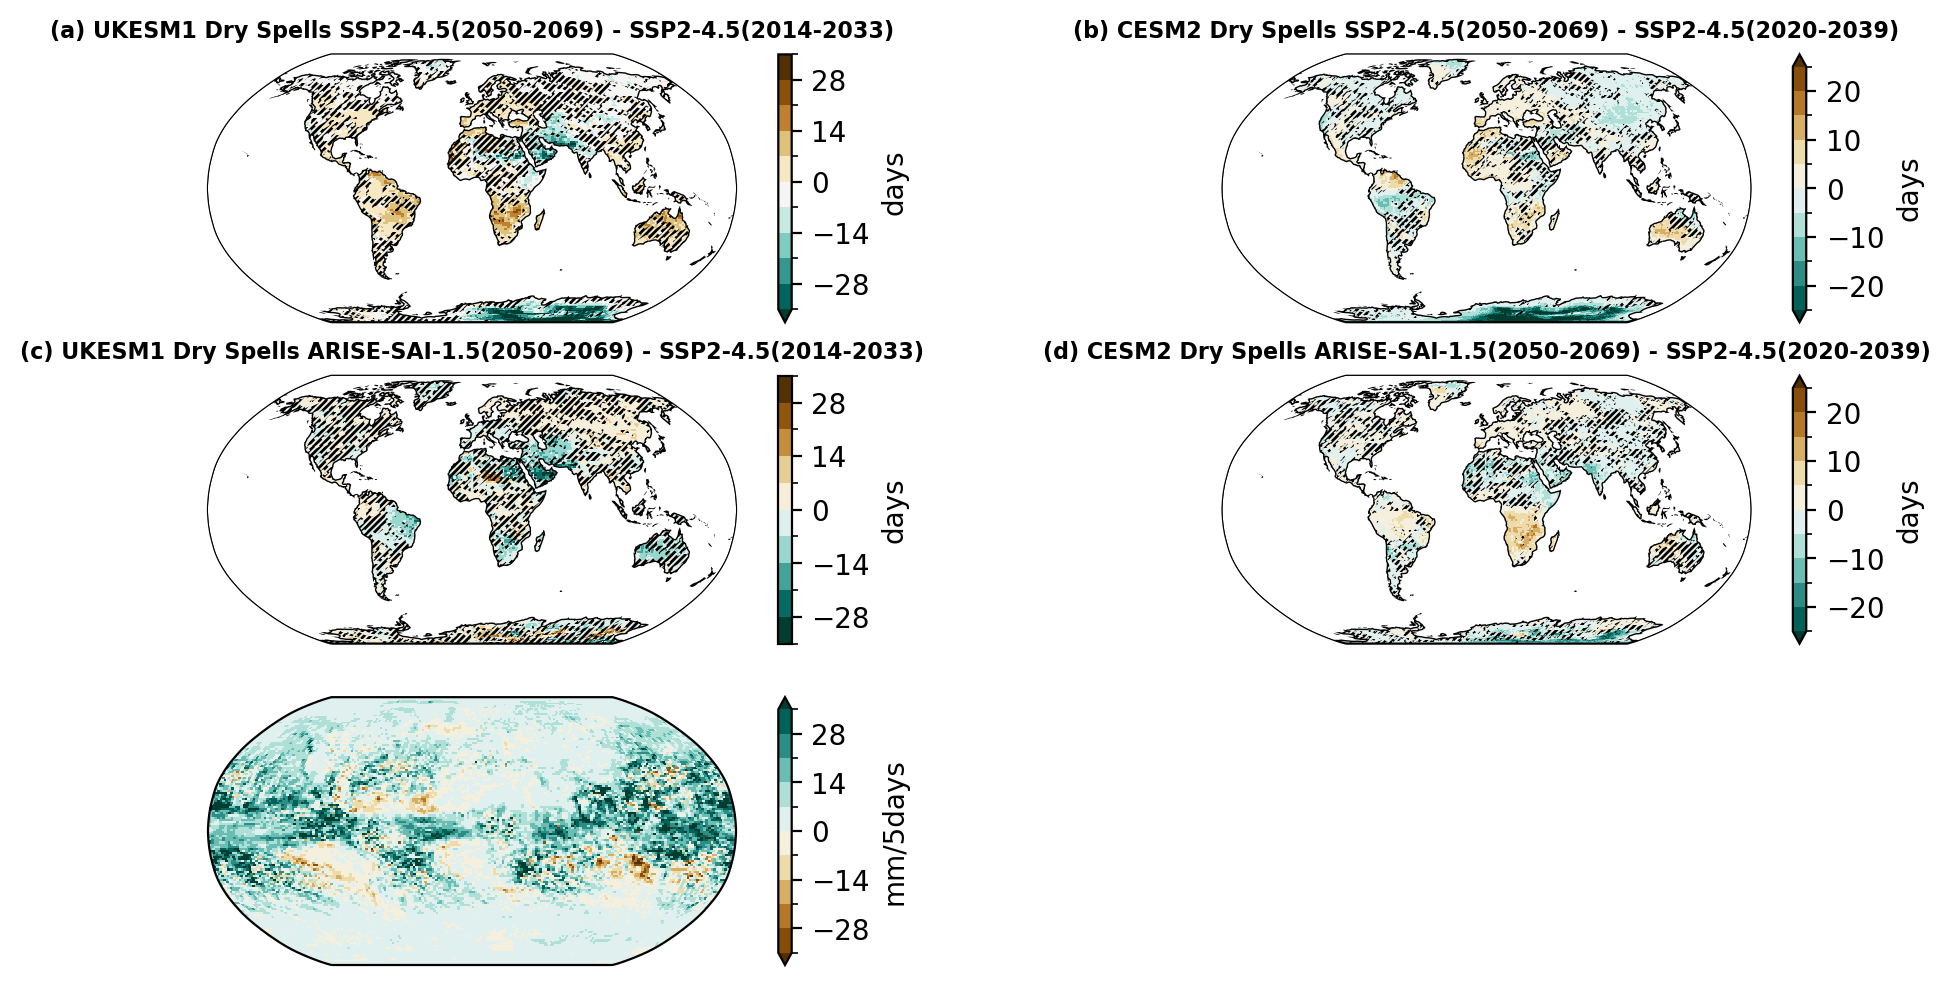

In [ ]:
fig = plt.figure(figsize=(12,8),dpi=200)

ax3 = fig.add_subplot(4,2, 1, projection=ccrs.Robinson())

####panel a 

pa = ukesm_ssp_cdd.plot(
      vmin=-35,vmax=35,levels=11,cmap='BrBG_r',
      subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
      transform=ccrs.PlateCarree(),
      cbar_kwargs={"shrink": 1, "label":"days"})
#pa.oceans
puk_cdd_ssp.where(puk_cdd_ssp>0.05).plot.contourf(levels=[0,1], colors='none', hatches=['//////////'],add_colorbar=False,subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
             transform=ccrs.PlateCarree())
ax3.set_title("(a) UKESM1 Dry Spells SSP2-4.5(2050-2069) - SSP2-4.5(2014-2033)", fontsize=8,fontweight='bold')
ax3.coastlines()
ax3.add_feature(cartopy.feature.OCEAN, zorder=10, facecolor='white', edgecolor='none')



####Panel b
ax3 = fig.add_subplot(4,2, 2, projection=ccrs.Robinson())
pb = cesm_ssp_cdd.plot(
      vmin=-25,vmax=25,levels=11,cmap='BrBG_r',
      subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
      transform=ccrs.PlateCarree(),
      cbar_kwargs={"shrink": 1, "label":"days"})
pcesm_cdd_ssp.where(pcesm_cdd_ssp>0.05).plot.contourf(levels=[0,1], colors='none', hatches=['//////////'],add_colorbar=False,subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
             transform=ccrs.PlateCarree())
ax3.set_title("(b) CESM2 Dry Spells SSP2-4.5(2050-2069) - SSP2-4.5(2020-2039)", fontsize=8,fontweight='bold')
ax3.coastlines()
ax3.add_feature(cartopy.feature.OCEAN, zorder=10, facecolor='white', edgecolor='none')

##### Panel c
ax3 = fig.add_subplot(4,2, 3, projection=ccrs.Robinson())
pc = ukesm_arise_cdd.plot(
      vmin=-35,vmax=35,levels=11,cmap='BrBG_r',
      subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
      transform=ccrs.PlateCarree(),
      cbar_kwargs={"shrink": 1, "label":"days"})
puk_cdd_arise.where(puk_cdd_arise>0.05).plot.contourf(levels=[0,1], colors='none', hatches=['//////////'],add_colorbar=False,subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
             transform=ccrs.PlateCarree())
ax3.set_title("(c) UKESM1 Dry Spells ARISE-SAI-1.5(2050-2069) - SSP2-4.5(2014-2033)", fontsize=8,fontweight='bold')
ax3.coastlines()
ax3.add_feature(cartopy.feature.OCEAN, zorder=10, facecolor='white', edgecolor='none')

##### panel d
ax3 = fig.add_subplot(4,2, 4, projection=ccrs.Robinson())

pd = cesm_arise_cdd.plot(
      vmin=-25,vmax=25,levels=11,cmap='BrBG_r',
      subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
      transform=ccrs.PlateCarree(),
      cbar_kwargs={"shrink": 1, "label":"days"})
pcesm_cdd_arise.where(pcesm_cdd_arise>0.05).plot.contourf(levels=[0,1], colors='none', hatches=['//////////'],add_colorbar=False,subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
             transform=ccrs.PlateCarree())
ax3.set_title("(d) CESM2 Dry Spells ARISE-SAI-1.5(2050-2069) - SSP2-4.5(2020-2039)", fontsize=8,fontweight='bold')
ax3.coastlines()
ax3.add_feature(cartopy.feature.OCEAN, zorder=10, facecolor='white', edgecolor='none')

##### panel e
ax3 = fig.add_subplot(4,2, 5, projection=ccrs.Robinson())
pe = ukesm_ssp_rx5d.plot(
      vmin=-35,vmax=35,levels=11,cmap='BrBG',
      subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
      transform=ccrs.PlateCarree(),
      cbar_kwargs={"shrink": 1, "label":"mm/5days"})
puk_rx5d_ssp.where(pcesm_rx5d_ssp>0.05).plot.contourf(levels=[0,1], colors='none', hatches=['//////////'],add_colorbar=False,subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
             transform=ccrs.PlateCarree())
ax3.set_title("(e) UKESM1 Wettest Pentad SSP2-4.5(2050-2069) - SSP2-4.5(2014-2033)", fontsize=8,fontweight='bold')
ax3.coastlines()
ax3.add_feature(cartopy.feature.OCEAN, zorder=10, facecolor='white', edgecolor='none')



####Panel f
ax3 = fig.add_subplot(4,2, 6, projection=ccrs.Robinson())
pf = cesm_ssp_rx5d.plot(
      vmin=-35,vmax=35,levels=11,cmap='BrBG',
      subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
      transform=ccrs.PlateCarree(),
      cbar_kwargs={"shrink": 1, "label":"mm/5days"})
pcesm_rx5d_ssp.where(pcesm_rx5d_ssp>0.05).plot.contourf(levels=[0,1], colors='none', hatches=['//////////'],add_colorbar=False,subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
             transform=ccrs.PlateCarree())
ax3.set_title("(f) CESM2 Wettest Pentad SSP2-4.5(2050-2069) - SSP2-4.5(2020-2039)", fontsize=8,fontweight='bold')
ax3.coastlines()
ax3.add_feature(cartopy.feature.OCEAN, zorder=10, facecolor='white', edgecolor='none')

##### Panel g
ax3 = fig.add_subplot(4,2, 7, projection=ccrs.Robinson())
pg = ukesm_arise_rx5d.plot(
      vmin=-20,vmax=20,levels=11,cmap='BrBG',
      subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
      transform=ccrs.PlateCarree(),
      cbar_kwargs={"shrink": 1, "label":"mm/5days"})
ax3.set_title("(g) UKESM1 Wettest Pentad ARISE-SAI-1.5(2050-2069) - SSP2-4.5(2014-2033)", fontsize=8,fontweight='bold')
ax3.coastlines()
ax3.add_feature(cartopy.feature.OCEAN, zorder=10, facecolor='white', edgecolor='none')

##### panel h
ax3 = fig.add_subplot(4,2, 8, projection=ccrs.Robinson())

ph = cesm_arise_rx5d.plot(
      vmin=-20,vmax=20,levels=11,cmap='BrBG',
      subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
      transform=ccrs.PlateCarree(),
      cbar_kwargs={"shrink": 1, "label":"mm/5days"})
ax3.set_title("(h) CESM2 Wettest Pentad ARISE-SAI-1.5(2050-2069) - SSP2-4.5(2020-2039)", fontsize=8,fontweight='bold')
ax3.coastlines()
ax3.add_feature(cartopy.feature.OCEAN, zorder=10, facecolor='white', edgecolor='none')

####other
plt.tight_layout()

plt.savefig(oDir + 'PrecipExt_land_map_CDD_RX5D.pdf',bbox_inches='tight')
plt.show()